# Loading Data

In [55]:
import pandas as pd
import numpy as np
from pathlib import Path

def load_tsv(path):
    df = pd.read_csv(path,sep="\t")
    df = df.set_index(df.columns[0])
    return df

# Paths (replace with your actual paths or URLs you’ve downloaded)
ra_tr = load_tsv("./training_data/ra_train_data.tsv");   ra_te = load_tsv("./test_data/ra_test_data.tsv")
sle_tr = load_tsv("./training_data/sle_train_data.tsv"); sle_te = load_tsv("./test_data/sle_test_data.tsv")
healthy_tr = load_tsv("./training_data/healthy_train_data.tsv"); healthy_te = load_tsv("./test_data/healthy_test_data.tsv")

genes = set(ra_tr.columns) & set(ra_te.columns) & set(sle_tr.columns) & set(sle_te.columns) & set(healthy_tr.columns) & set(healthy_te.columns)
genes = sorted(genes)

print("Number of genes per dataset:")
print("RA train:", ra_tr.shape[1])
print("RA test:", ra_te.shape[1])
print("SLE train:", sle_tr.shape[1])
print("SLE test :", sle_te.shape[1])
print("Healthy train :", healthy_tr.shape[1])
print("Healthy test :", healthy_te.shape[1])
print("\nGenes in intersection:", len(genes))


Number of genes per dataset:
RA train: 37691
RA test: 37691
SLE train: 37691
SLE test : 37691
Healthy train : 24403
Healthy test : 24403

Genes in intersection: 24403


In [56]:

training_data = pd.concat([
    healthy_tr.loc[:,genes].assign(label="Healthy"),
    ra_tr.loc[:,genes].assign(label="RA"),
    sle_tr.loc[:,genes].assign(label="SLE"),
])
test_data = pd.concat([
    healthy_te.loc[:,genes].assign(label="Healthy"),
    ra_te.loc[:,genes].assign(label="RA"),
    sle_te.loc[:,genes].assign(label="SLE"),
])

y_tr = training_data.pop("label")
y_te = test_data.pop("label")

print("\nTraining data shape:", training_data.shape)
print("Test data shape:", test_data.shape)



Training data shape: (3221, 24403)
Test data shape: (895, 24403)


## Studying data

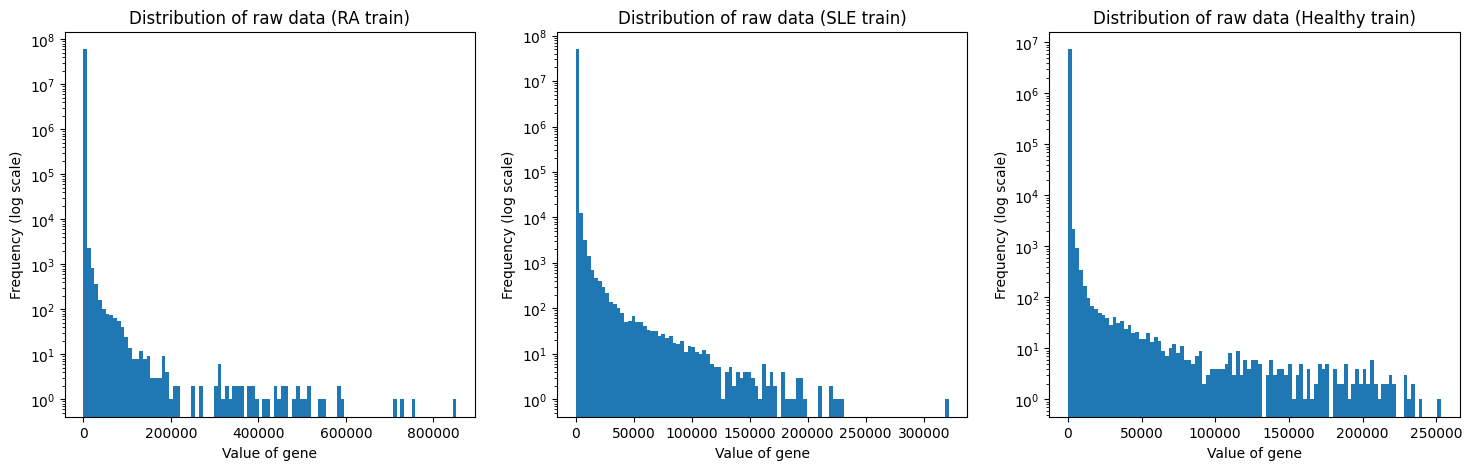

In [57]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
datasets = [
    (ra_tr, "RA train"),
    (sle_tr, "SLE train"),
    (healthy_tr, "Healthy train")
]

for ax, (df, title) in zip(axes, datasets):
    flat = df.values.flatten()
    ax.hist(flat, bins=100)
    ax.set_yscale("log")
    ax.set_title(f"Distribution of raw data ({title})")
    ax.set_xlabel("Value of gene")
    ax.set_ylabel("Frequency (log scale)")

plt.show()

>It appears that the data is really skewed because most genes are nearly silent while a few genes dominate the exchanges.
FPKM normalization does not change this behiavour.
This is why a log transformation is relevant for making the data suitable for machine learning.

In [58]:
zero_fraction = (ra_tr.values == 0).flatten().sum() / ra_tr.values.size
print("Fraction of zeros in RA train:", zero_fraction)

Fraction of zeros in RA train: 0.6730478095712028


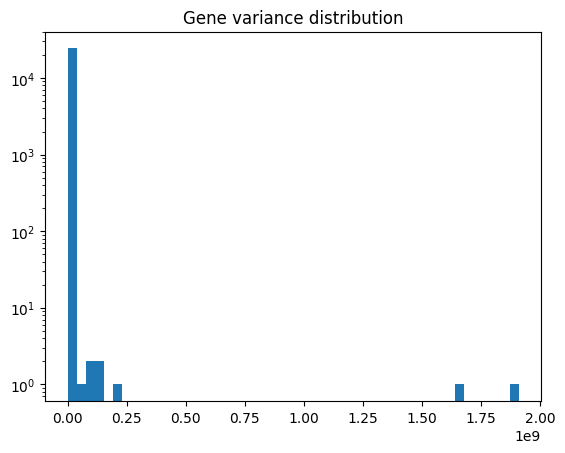

In [59]:
gene_var = training_data.var(axis=0)
plt.hist(gene_var, bins=50)
plt.yscale("log")
plt.title("Gene variance distribution")
plt.show()

>A lot of genes have really small variance. The interesting ones are those with high variances.

## Pre Processing data

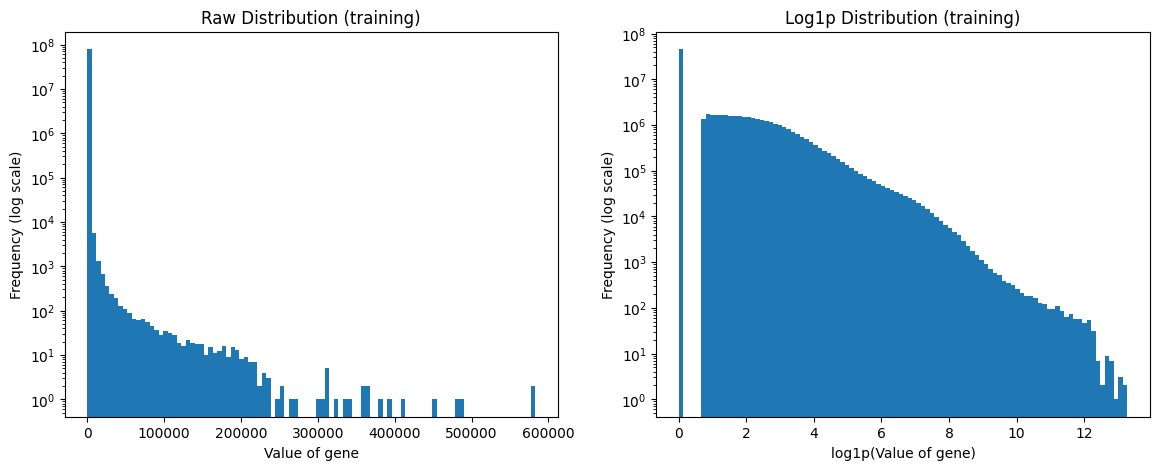

In [60]:
import numpy as np
import matplotlib.pyplot as plt

raw = training_data.values.flatten()

log_raw = np.log1p(training_data.values).flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(raw, bins=100)
axes[0].set_yscale("log")
axes[0].set_title("Raw Distribution (training)")
axes[0].set_xlabel("Value of gene")
axes[0].set_ylabel("Frequency (log scale)")

axes[1].hist(log_raw, bins=100)
axes[1].set_yscale("log")
axes[1].set_title("Log1p Distribution (training)")
axes[1].set_xlabel("log1p(Value of gene)")
axes[1].set_ylabel("Frequency (log scale)")

plt.show()


In [61]:
Xtr_log = np.log1p(training_data.values)
Xte_log = np.log1p(test_data.values)

gene_var = Xtr_log.var(axis=0)
threshold = np.quantile(gene_var, 0.5) # eventuellement ajuster le quantile
mask = gene_var >= threshold

Xtr_filt = Xtr_log[:, mask]
Xte_filt = Xte_log[:, mask]

print("Number of genes before filtering:", training_data.shape[1])
print("Number of genes after filtering:", Xtr_filt.shape[1])



Number of genes before filtering: 24403
Number of genes after filtering: 12202


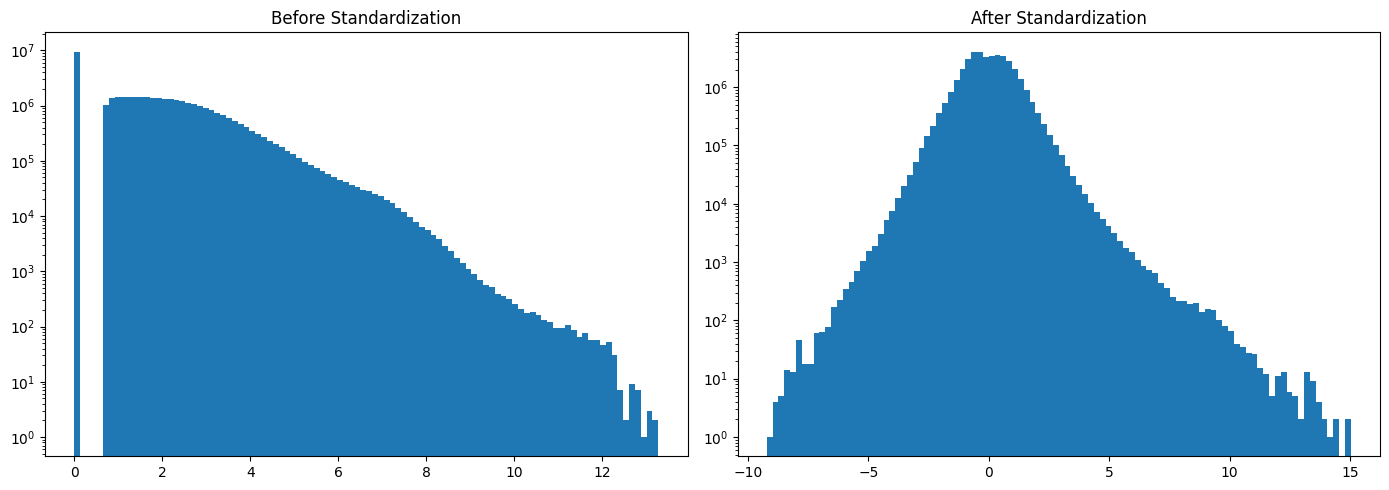

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(Xtr_filt)
Xtr_z = scaler.transform(Xtr_filt)
Xte_z = scaler.transform(Xte_filt)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(Xtr_filt.flatten(), bins=100)
axes[0].set_yscale("log")
axes[0].set_title("Before Standardization")
axes[1].hist(Xtr_z.flatten(), bins=100)
axes[1].set_yscale("log")
axes[1].set_title("After Standardization")
plt.tight_layout()
plt.show()

## We can see a gaussian like distribution after standardization which is good.

## Choosing the ML-Model

## **ID3** (naive)

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    Xtr_z, y_tr, test_size=0.2, random_state=42, stratify=y_tr
)

In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

dt = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=None,
    random_state=42,
)

dt.fit(X_train, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None



#### Model Validation and Evaluation

For this classification task, we will use metrics that treat all classes fairly : Precision, Recall and macro F1-score.


$$\text{Precision} = \frac{TP}{TP+FP}$$

  
\
$$\text{Recall} = \frac{TP}{TP+FN}$$

\
$$F_1 = 2 \cdot \frac{\text{Precision}\cdot \text{Recall}}{\text{Precision}+\text{Recall}}$$


---

### What is really important in our case ? 

- false positive : unncecessary concern and treatment (Precision)
- false negative : failing to detect disease = much worse  (Recall)
  
That's why the most meaningful metric is F1 score in our case (or fbeta_score if we want the recall to be more important ; this is what we chose with Beta = 2)



In [65]:
from sklearn.metrics import (
    classification_report,
    fbeta_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
train_pred = dt.predict(X_train)
valid_pred = dt.predict(X_valid)
test_pred = dt.predict(Xte_z)

print(f"Train Fβ=2 (macro): {fbeta_score(y_train, train_pred, average='macro', beta=2):.3f}")
print(f"Valid Fβ=2 (macro): {fbeta_score(y_valid, valid_pred, average='macro', beta=2):.3f}")
print(f"Test Fβ=2 (macro): {fbeta_score(y_te, test_pred, average='macro', beta=2):.3f}")
print()

# print("Classification report (validation):")
# print(classification_report(y_valid, valid_pred))
# print("Classification report (test):")
# print(classification_report(y_te, test_pred))




Train Fβ=2 (macro): 0.999
Valid Fβ=2 (macro): 0.952
Test Fβ=2 (macro): 0.793



| Set | Fβ=2 (macro) | Interpretation |
|-|-|-|
| **Train** | 0.999 | strong memorization |
| **Validation** | 0.952 | minor overfitting but good internal generalization. |
| **Test** | 0.793 | significant drop : generalization to unseen data is weaker, even though the performance is not terrible (see the confusion matrix) |

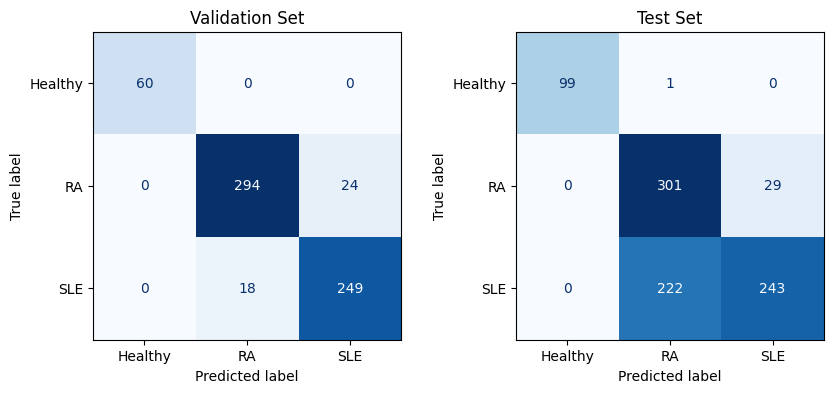

In [66]:
cm_val = confusion_matrix(y_valid, valid_pred, labels=dt.classes_)
cm_test = confusion_matrix(y_te, test_pred, labels=dt.classes_)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=dt.classes_)
disp_val.plot(cmap="Blues",ax=axes[0], colorbar=False)
axes[0].set_title("Validation Set")

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=dt.classes_)
disp_test.plot(cmap="Blues", ax=axes[1], colorbar=False)
axes[1].set_title("Test Set")

plt.show()

>Conclusion

- ID3 achieved almost perfect training and validation results but dropped on the test set (Fβ=2 from 0.94 to 0.77), showing clear overfitting.  

- It distinguishes healthy samples very well but confuses RA and SLE. 


### Bonus : tuning the tree to reduce overfitting

In [67]:
dt_reg = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=4,            
    random_state=42,
    # min_samples_leaf=10
)
dt_reg.fit(X_train, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [68]:
train_pred = dt_reg.predict(X_train)
valid_pred = dt_reg.predict(X_valid)
test_pred = dt_reg.predict(Xte_z)
print(f"Train Fβ=2 (macro): {fbeta_score(y_train, train_pred, average='macro', beta=2):.3f}")
print(f"Valid Fβ=2 (macro): {fbeta_score(y_valid, valid_pred, average='macro', beta=2):.3f}")
print(f"Test Fβ=2 (macro): {fbeta_score(y_te, test_pred, average='macro', beta=2):.3f}")
print()

# print("Classification report (validation):")
# print(classification_report(y_valid, valid_pred))
# print("Classification report (test):")
# print(classification_report(y_te, test_pred))



Train Fβ=2 (macro): 0.895
Valid Fβ=2 (macro): 0.873
Test Fβ=2 (macro): 0.777



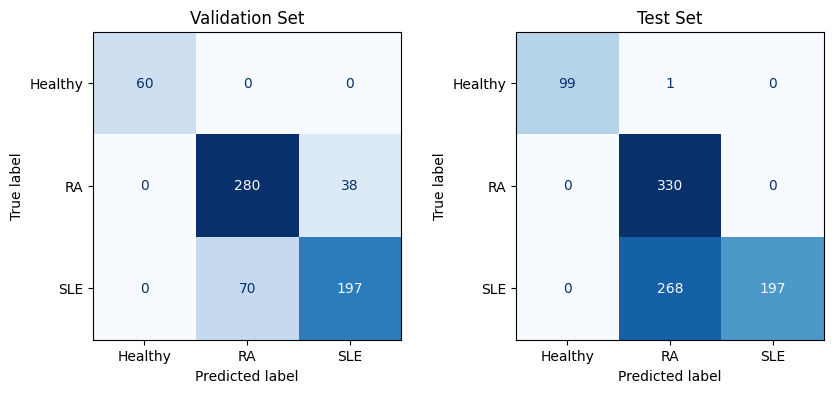

In [69]:
cm_val2 = confusion_matrix(y_valid, valid_pred, labels=dt.classes_)
cm_test2 = confusion_matrix(y_te, test_pred, labels=dt.classes_)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

disp_val2 = ConfusionMatrixDisplay(confusion_matrix=cm_val2, display_labels=dt.classes_)
disp_val2.plot(cmap="Blues",ax=axes[0], colorbar=False)
axes[0].set_title("Validation Set")

disp_test2 = ConfusionMatrixDisplay(confusion_matrix=cm_test2, display_labels=dt.classes_)
disp_test2.plot(cmap="Blues", ax=axes[1], colorbar=False)
axes[1].set_title("Test Set")

plt.show()

## **XGBoost**

In [70]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

Xtr_log = np.log1p(training_data.values)
Xte_log = np.log1p(test_data.values)
gene_var = Xtr_log.var(axis=0)
threshold = np.quantile(gene_var, 0.96) # Changed because the fit of XGB was too long with top 50% variance genes
mask = gene_var >= threshold
Xtr_filt = Xtr_log[:, mask]
Xte_filt = Xte_log[:, mask]

scaler = StandardScaler().fit(Xtr_filt)
Xtr_z = scaler.transform(Xtr_filt)
Xte_z = scaler.transform(Xte_filt)

X_tr, y_tr = Xtr_z, y_tr
X_te, y_te = Xte_z, y_te
le = LabelEncoder()
y_tr_encoded = le.fit_transform(y_tr)
y_te_encoded = le.transform(y_te)

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    tree_method="hist",
    n_estimators=6000,        
    learning_rate=0.2,       
    subsample=0.04,            
    colsample_bytree=0.35,     
    reg_lambda=1.0,          
    reg_alpha=0.1,            
    early_stopping_rounds=100, 
    random_state=290
)

X_tr_in, X_val_in, y_tr_in, y_val_in = train_test_split(
    X_tr, y_tr_encoded, test_size=0.2, random_state=42, stratify=y_tr_encoded
)


xgb.fit(
    X_tr_in, y_tr_in,
    eval_set=[(X_val_in, y_val_in)],
    verbose=False,
)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.35
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,None


In [71]:

# Evaluation (recall-focused macro Fβ=2)
y_val_pred = xgb.predict(X_val_in)
y_te_pred  = xgb.predict(X_te)


print("Train Fβ=2 (macro):", fbeta_score(y_tr_in, xgb.predict(X_tr_in), average="macro", beta=2))
print("Val Fβ=2 (macro):", fbeta_score(y_val_in, y_val_pred, average="macro", beta=2))
print("Test Fβ=2 (macro):", fbeta_score(y_te_encoded, y_te_pred, average="macro", beta=2))

# y_te_pred_labels = le.inverse_transform(y_te_pred)
# print("\nClassification report (Test):\n", classification_report(y_te, y_te_pred_labels))
# print("Classification report (Validation):\n", classification_report(y_val_in, y_val_pred))

Train Fβ=2 (macro): 0.9953641076071418
Val Fβ=2 (macro): 0.981626740159706
Test Fβ=2 (macro): 0.9410628019323672


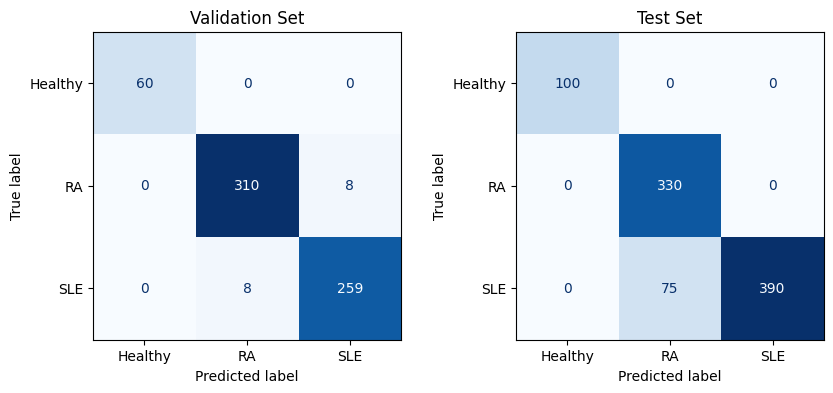

In [72]:

cm_val3 = confusion_matrix(le.inverse_transform(y_val_in), le.inverse_transform(y_val_pred), labels=dt.classes_)
cm_test3 = confusion_matrix(le.inverse_transform(y_te_encoded), le.inverse_transform(y_te_pred), labels=dt.classes_)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

disp_val3 = ConfusionMatrixDisplay(confusion_matrix=cm_val3, display_labels=dt.classes_)
disp_val3.plot(cmap="Blues",ax=axes[0], colorbar=False)
axes[0].set_title("Validation Set")

disp_test3 = ConfusionMatrixDisplay(confusion_matrix=cm_test3, display_labels=dt.classes_)
disp_test3.plot(cmap="Blues", ax=axes[1], colorbar=False)
axes[1].set_title("Test Set")

plt.show()

>Observation :
The model seems to have some difficulty with correctly identifying SLE samples in the test data. It suggests that it may have learned patterns that are too specific to the training data. We will try to fix that by adding class weighting during training ; thus giving higher importance to SLE samples.

In [92]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np


class_weight = {"Healthy": 1.0, "RA": 1.0, "SLE": 1.5} # class weighting to give more importance to SLE samples

le = LabelEncoder()
y_tr_encoded = le.fit_transform(y_tr)
y_te_encoded = le.transform(y_te)

X_tr, X_te = Xtr_z, Xte_z

X_tr_in, X_val_in, y_tr_in, y_val_in = train_test_split(
    X_tr, y_tr_encoded, test_size=0.2, random_state=42, stratify=y_tr_encoded
)


label_to_weight = {le.transform([name])[0]: w for name, w in class_weight.items()}

sw_tr  = np.array([label_to_weight[c] for c in y_tr_in], dtype=float)
sw_val = np.array([label_to_weight[c] for c in y_val_in], dtype=float)
sw_te  = np.array([label_to_weight[c] for c in y_te_encoded], dtype=float)


dic = {le.transform([k])[0]: v for k, v in class_weight.items()}

sw_tr  = np.array([dic[c] for c in y_tr_in], dtype=float)
sw_val = np.array([dic[c] for c in y_val_in], dtype=float)
sw_te  = np.array([dic[c] for c in y_te_encoded], dtype=float)

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    tree_method="hist",
    n_estimators=6000,        
    learning_rate=0.2,       
    subsample=0.04,            
    colsample_bytree=0.35,     
    reg_lambda=1.0,          
    reg_alpha=0.1,            
    early_stopping_rounds=250, 
    random_state=42
)

xgb.fit(
        X_tr_in,
        y_tr_in,
        sample_weight=sw_tr,
        eval_set=[(X_val_in, y_val_in)],
        sample_weight_eval_set=[sw_val],              
        verbose=False,
    )

   


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.35
,device,None
,early_stopping_rounds,250
,enable_categorical,False
,eval_metric,None


In [93]:

y_val_pred = xgb.predict(X_val_in)
y_te_pred  = xgb.predict(X_te)


print("Train Fβ=2 (macro):", fbeta_score(y_tr_in, xgb.predict(X_tr_in), average="macro", beta=2))
print("Val Fβ=2 (macro):", fbeta_score(y_val_in, y_val_pred, average="macro", beta=2))
print("Test Fβ=2 (macro):", fbeta_score(y_te_encoded, y_te_pred, average="macro", beta=2))

Train Fβ=2 (macro): 0.9991815964498084
Val Fβ=2 (macro): 0.984277902063137
Test Fβ=2 (macro): 0.9774017220304936


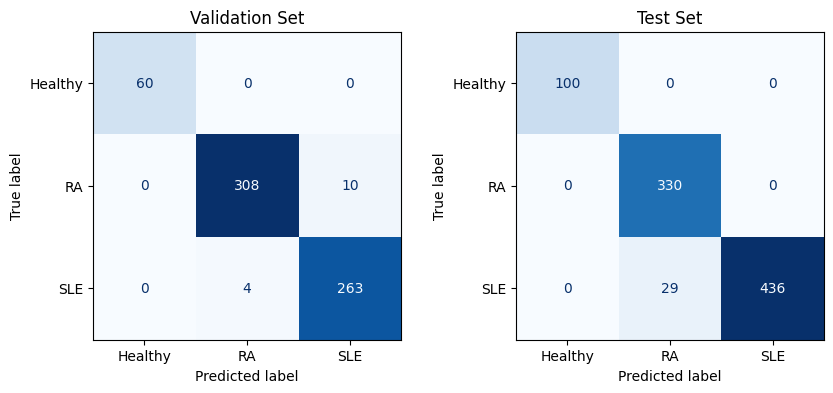

In [94]:

cm_val3 = confusion_matrix(le.inverse_transform(y_val_in), le.inverse_transform(y_val_pred), labels=dt.classes_)
cm_test3 = confusion_matrix(le.inverse_transform(y_te_encoded), le.inverse_transform(y_te_pred), labels=dt.classes_)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

disp_val3 = ConfusionMatrixDisplay(confusion_matrix=cm_val3, display_labels=dt.classes_)
disp_val3.plot(cmap="Blues",ax=axes[0], colorbar=False)
axes[0].set_title("Validation Set")

disp_test3 = ConfusionMatrixDisplay(confusion_matrix=cm_test3, display_labels=dt.classes_)
disp_test3.plot(cmap="Blues", ax=axes[1], colorbar=False)
axes[1].set_title("Test Set")

plt.show()

> Conclusion : XGBoost model clearly outperforms ID3 after slight parameter tuning. It demonstrates strong generalization across unseen data, indicating that boosting successfully improved both robustness and accuracy.

# Analysis of the results

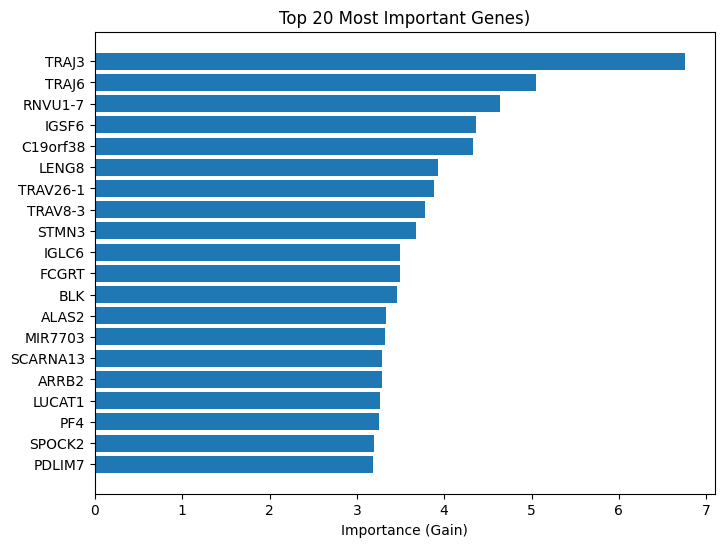

In [95]:
from xgboost import plot_importance
gene_names = training_data.columns[mask]

importance = xgb.get_booster().get_score(importance_type='gain')

# for k,v in importance.items():
#     print(k, gene_names[int(k[1:])], v)

dic = {
    gene_names[int(k[1:])]: v for k, v in importance.items()
}

imp_df = pd.DataFrame({
    'Gene': dic.keys(),
    'Importance': dic.values()
}).sort_values(by='Importance', ascending=False)


top_genes = imp_df.head(20)
plt.figure(figsize=(8,6))
plt.barh(top_genes['Gene'], top_genes['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance (Gain)")
plt.title("Top 20 Most Important Genes)")
plt.show()


> Quick research on ZNF467 and MEFV for example confirms that they are linked to the immune system activity.
- https://v22.proteinatlas.org/ENSG00000181444-ZNF467/immune%2Bcell
- https://v22.proteinatlas.org/ENSG00000103313-MEFV/immune%2Bcell

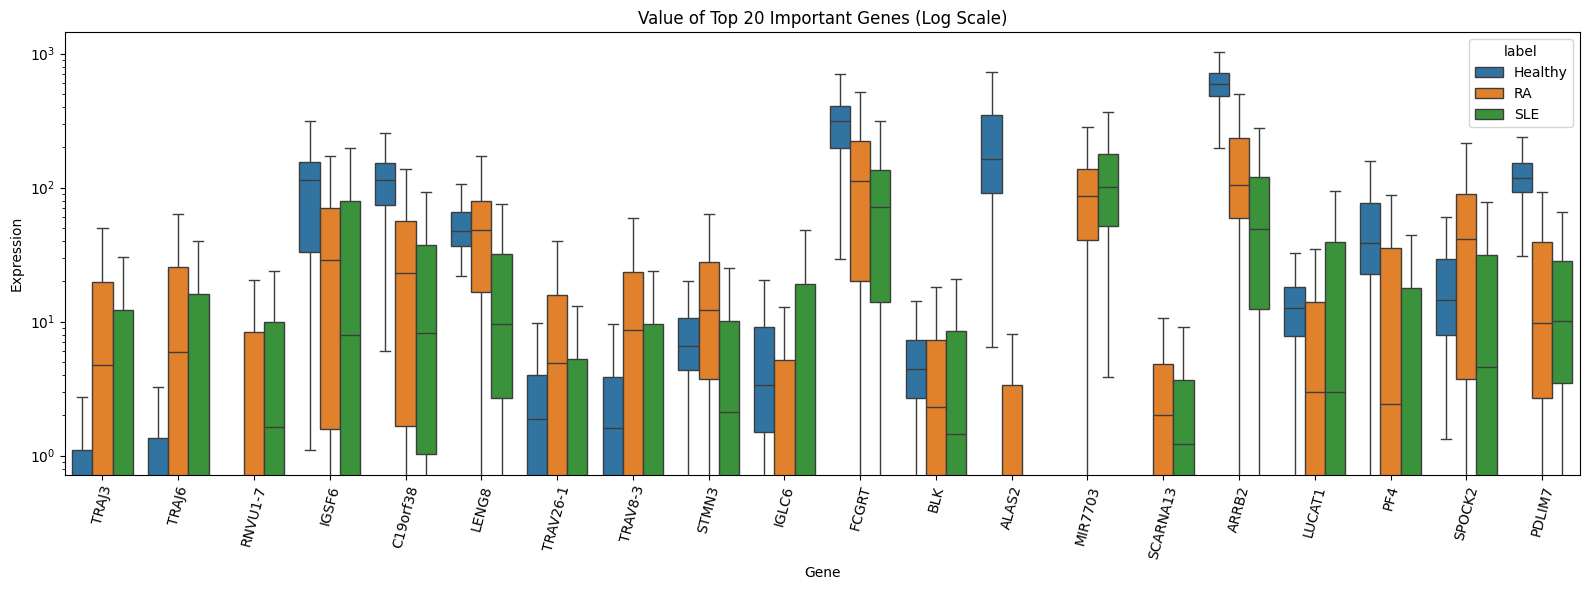

In [96]:
import seaborn as sns

top_gene_names = top_genes['Gene'].values
subset = training_data[top_gene_names].copy()
subset['label'] = y_tr.values

melted = subset.melt(id_vars='label', var_name='Gene', value_name='Expression')

plt.figure(figsize=(16,6))
sns.boxplot(data=melted, x='Gene', y='Expression', hue='label', showfliers=False)
plt.xticks(rotation=75)
plt.yscale('log')
plt.title('Value of Top 20 Important Genes (Log Scale)')
plt.tight_layout()
plt.show()

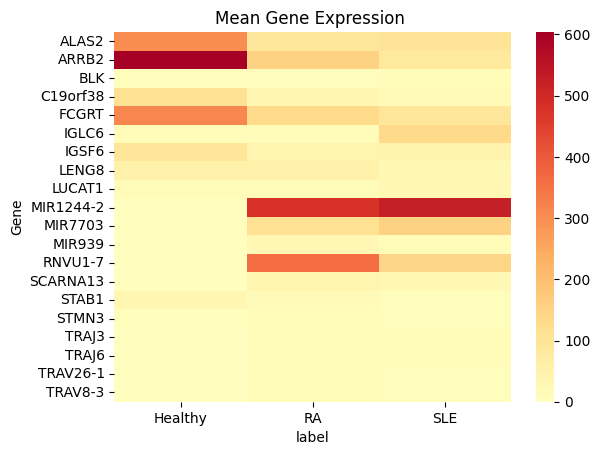

In [78]:
mean_expr = melted.groupby(['Gene', 'label'])['Expression'].mean().unstack()
sns.heatmap(mean_expr, cmap="RdYlBu_r", center=0)
plt.title("Mean Gene Expression ")
plt.show()

> We can easily recognize certain patterns : (to be discussed)

In [79]:
def find_best_threshold_balanced_acc(values, labels, positive_label, negative_label):
    """
    Find a threshold τ on `values` that best separates positive_label vs negative_label
    using balanced accuracy = 0.5 * (recall + specificity).
    """
    mask = np.isin(labels, [positive_label, negative_label])
    vals = values[mask]
    labs = labels[mask]

    y_true = (labs == positive_label).astype(int)

    thr_candidates = np.percentile(vals, np.linspace(5, 95, 50))

    best_thr = None
    best_score = -1.0

    for thr in thr_candidates:
        y_pred = (vals >= thr).astype(int)

        tp = np.sum((y_pred == 1) & (y_true == 1))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        recall = tp / (tp + fn + 1e-8)
        spec   = tn / (tn + fp + 1e-8)
        score  = 0.5 * (recall + spec)

        if score > best_score:
            best_score = score
            best_thr = thr

    return best_thr, best_score


def significant_thresholds(training_data, y_tr, top_genes):
    top_gene_names = top_genes["Gene"].values
    df = training_data[top_gene_names].copy()
    df["label"] = y_tr.values

    melted = df.melt(id_vars="label", var_name="Gene", value_name="Expression")

    thresholds = {}

    for gene in top_gene_names:
        g = melted[melted["Gene"] == gene].copy()

        # Healthy vs sick
        labels_bin = np.where(g["label"] == "Healthy", "Healthy", "Sick")
        g["bin_label"] = labels_bin

        mean_healthy = g.loc[g["bin_label"] == "Healthy", "Expression"].mean()
        mean_sick    = g.loc[g["bin_label"] == "Sick", "Expression"].mean()

        if mean_healthy >= mean_sick:
            hs_pos, hs_neg = "Healthy", "Sick"
        else:
            hs_pos, hs_neg = "Sick", "Healthy"

        hs_thr, hs_score = find_best_threshold_balanced_acc(
            g["Expression"].values,
            g["bin_label"].values,
            positive_label=hs_pos,
            negative_label=hs_neg,
        )

        # RA vs SLE
        g_rs = g[g["label"].isin(["RA", "SLE"])].copy()

        mean_ra  = g_rs.loc[g_rs["label"] == "RA",  "Expression"].mean()
        mean_sle = g_rs.loc[g_rs["label"] == "SLE", "Expression"].mean()

        if mean_ra >= mean_sle:
            rs_pos, rs_neg = "RA", "SLE"
        else:
            rs_pos, rs_neg = "SLE", "RA"

        rs_thr, rs_score = find_best_threshold_balanced_acc(
            g_rs["Expression"].values,
            g_rs["label"].values,
            positive_label=rs_pos,
            negative_label=rs_neg,
        )

        thresholds[gene] = {
            "healthy_vs_sick": {
                "positive": hs_pos,
                "negative": hs_neg,
                "threshold": hs_thr,
                "balanced_acc": hs_score,
                "mean_healthy": float(mean_healthy),
                "mean_sick": float(mean_sick),
            },
            "ra_vs_sle": {
                "positive": rs_pos,
                "negative": rs_neg,
                "threshold": rs_thr,
                "balanced_acc": rs_score,
                "mean_ra": float(mean_ra) if g_rs.size else np.nan,
                "mean_sle": float(mean_sle) if g_rs.size else np.nan,
            },
        }

    return thresholds


In [80]:
thresholds = significant_thresholds(training_data, y_tr, top_genes)

# Top 2 genes for Healthy vs Sick
hs_sorted = sorted(
    thresholds.items(),
    key=lambda item: item[1]["healthy_vs_sick"]["balanced_acc"],
    reverse=True,
)
top2_hs = hs_sorted[:2]

print("TOP GENES: HEALTHY vs SICK\n")
for gene, info in top2_hs:
    hs = info["healthy_vs_sick"]
    print(f"Gene: {gene}")
    print(
        f"If expression ≥ {hs['threshold']:.3f}, patient must be {hs['positive']}, "
        f"else patient must be {hs['negative']} "
        f"(Balanced accuracy = {hs['balanced_acc']:.3f})\n"
    )

# Top 2 genes for RA vs SLE
rs_sorted = sorted(
    thresholds.items(),
    key=lambda item: item[1]["ra_vs_sle"]["balanced_acc"],
    reverse=True,
)
top2_rs = rs_sorted[:2]

print("TOP GENES: RA vs SLE\n")
for gene, info in top2_rs:
    rs = info["ra_vs_sle"]
    if rs["positive"] is None:
        continue
    print(f"Gene: {gene}")
    print(
        f"If expression ≥ {rs['threshold']:.3f}, patient must be {rs['positive']}, "
        f"else patient must be {rs['negative']} "
        f"(Balanced accuracy = {rs['balanced_acc']:.3f})\n"
    )


TOP GENES: HEALTHY vs SICK

Gene: MIR7703
If expression ≥ 11.001, patient must be Sick, else patient must be Healthy (Balanced accuracy = 0.994)

Gene: MIR1244-2
If expression ≥ 12.736, patient must be Sick, else patient must be Healthy (Balanced accuracy = 0.994)

TOP GENES: RA vs SLE

Gene: LENG8
If expression ≥ 12.399, patient must be RA, else patient must be SLE (Balanced accuracy = 0.693)

Gene: STMN3
If expression ≥ 5.238, patient must be RA, else patient must be SLE (Balanced accuracy = 0.675)



# Auto Encoder

In [81]:
Xtr_log = np.log1p(training_data.values)
Xte_log = np.log1p(test_data.values)
gene_var = Xtr_log.var(axis=0)
threshold = np.quantile(gene_var, 0.96)
mask = gene_var >= threshold
Xtr_filt = Xtr_log[:, mask]
Xte_filt = Xte_log[:, mask]

scaler = StandardScaler().fit(Xtr_filt)
Xtr_z = scaler.transform(Xtr_filt)
Xte_z = scaler.transform(Xte_filt)


In [91]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cpu")

Xtr_z = Xtr_z.astype(np.float32)
Xte_z = Xte_z.astype(np.float32)
Xtr_t = torch.tensor(Xtr_z)
Xte_t = torch.tensor(Xte_z)

train_ds = TensorDataset(Xtr_t)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

in_dim = Xtr_z.shape[1]
latent_dim = 64  # to be adjusted

class AE(nn.Module):
    def __init__(self, in_dim, latent):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 1024), nn.ReLU(),
            nn.Linear(1024, 256), nn.ReLU(),
            nn.Linear(256, latent)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent, 256), nn.ReLU(),
            nn.Linear(256, 1024), nn.ReLU(),
            nn.Linear(1024, in_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        xrec = self.decoder(z)
        return xrec, z

ae = AE(in_dim, latent_dim)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-5)
crit = nn.MSELoss()

best_loss, leave, stall = float("inf"), 10, 0
for epoch in range(200):
    ae.train()
    epoch_loss = 0.0
    for (xb,) in train_dl:
        xrec, _ = ae(xb)
        loss = crit(xrec, xb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.item()*xb.size(0)
    epoch_loss /= len(train_ds)

    if epoch_loss + 1e-6 < best_loss:
        best_loss, stall = epoch_loss, 0
        best_state = {k: v.clone() for k, v in ae.state_dict().items()}
    else:
        stall += 1
    if stall >= leave:
        break

ae.load_state_dict(best_state)
ae.eval()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=977, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=977, bias=True)
  )
)

> We will do some tries with n_latent = 16, 32, 64, 128

In [97]:
@torch.no_grad()
def encode(ae, X):
    input_tensor = torch.tensor(X, dtype=torch.float32)
    _, Z = ae(input_tensor)
    return Z.numpy()

Z_tr = encode(ae, Xtr_z)   
Z_te = encode(ae, Xte_z)
print("Encoded train shape:", Z_tr.shape)


Encoded train shape: (3221, 64)


In [ ]:
le = LabelEncoder()
y_tr_enc = le.fit_transform(y_tr)
y_te_enc = le.transform(y_te)


xgb_latent = XGBClassifier( 
        objective="multi:softprob",
        num_class=3,
        tree_method="hist",
        n_estimators=6000,
        learning_rate=0.3,
        subsample=0.1,
        colsample_bytree=0.35,
        reg_lambda=4.0,
        reg_alpha=0,
        random_state=42,
)

xgb_latent.fit(Z_tr, y_tr_enc)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.35
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [120]:
y_te_pred = xgb_latent.predict(Z_te)
y_train_pred = xgb_latent.predict(Z_tr)
print("Test Fβ=2 (macro) on train:", fbeta_score(y_tr_enc, y_train_pred, average="macro", beta=2))
print("Test Fβ=2 (macro):", fbeta_score(y_te_enc, y_te_pred, average="macro", beta=2))


Test Fβ=2 (macro) on train: 0.999127453276103
Test Fβ=2 (macro): 0.9648346530041918


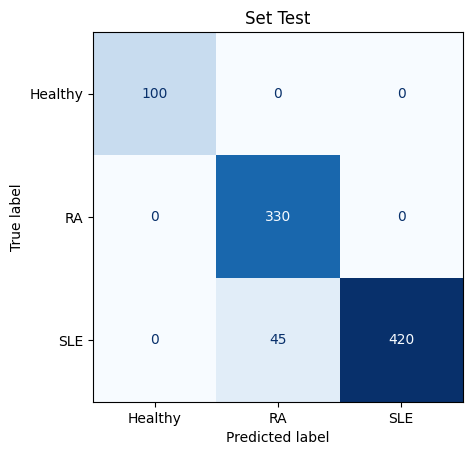

In [121]:
cm_test4 = confusion_matrix(le.inverse_transform(y_te_enc), le.inverse_transform(y_te_pred), labels=dt.classes_)
disp_test4 = ConfusionMatrixDisplay(confusion_matrix=cm_test4, display_labels=dt.classes_)
disp_test4.plot(cmap="Blues", colorbar=False)
plt.title("Set Test")

plt.show()

> It seems that the encoded input clearly helps with the accuracy : the auto encoder sucessfully learned a compact latent representation of the RNA. Moreover, it reduces dimensions and fasten xgb fitting for example.

> Cons : because we have now a latent input, we are not able to retrieve the genes that were important in the decision process